# Visual Transformer
Replicating architecture from following paper [https://arxiv.org/pdf/2010.11929]

In [13]:
import torch
import torchvision
import matplotlib.pyplot as plt
from typing import Tuple
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

Get data paths

In [5]:
current_directory_path = Path.cwd()
data_path = current_directory_path / "data"

train_data_path = data_path / "train"
test_data_path = data_path / "test"

In [4]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [10]:
def create_dataloaders(
    train_data_path: str | Path,
    test_data_path: str | Path,
    transforms: torchvision.transforms,
    batch_size: int,
    num_workers: int = 0
):
    # Create datasets
    train_dataset = datasets.ImageFolder(
        root=train_data_path,
        transform=transforms,
        target_transform=None
    )

    test_dataset = datasets.ImageFolder(
        root=test_data_path,
        transform=transforms
    )

    # Create dataloaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True
    )

    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True
    )

    # Get class names
    class_names = test_dataset.classes

    return train_dataloader, test_dataloader, class_names

In [11]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_data_path=train_data_path,
    test_data_path=test_data_path,
    transforms=manual_transforms,
    batch_size=32
)

Data loaded. Let's check one image

In [16]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

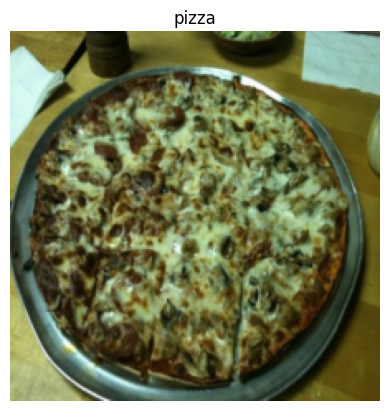

In [17]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

## Paper replicating

In [ ]:
PATCH_SIZE = 16
PATCHES_AMOUNT = int(pow(IMG_SIZE / PATCH_SIZE, 2))
PATCH_AREA = PATCH_SIZE * PATCH_SIZE
CHANNELS_AMOUNT = image.shape[0]
EMBEDDING_SIZE = PATCH_AREA * CHANNELS_AMOUNT
EMBEDDING_SIZE, PATCHES_AMOUNT, CHANNELS_AMOUNT

(768, 196, 3)

In [24]:
conv2d = torch.nn.Conv2d(
    in_channels=CHANNELS_AMOUNT,
    out_channels=EMBEDDING_SIZE,
    kernel_size=PATCH_SIZE,
    stride=PATCH_SIZE,
    padding=0
)

In [26]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)
# torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [505, 696, 176, 655, 534]


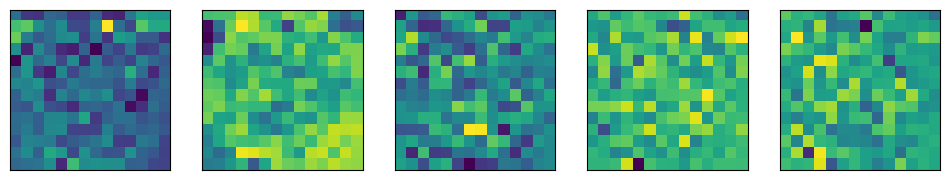

In [28]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, EMBEDDING_SIZE), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [29]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0896,  0.1850,  0.0797,  0.0184,  0.1826,  0.1670,  0.1759,
            0.0711, -0.0196, -0.0042,  0.1405,  0.0951,  0.1504,  0.1623],
          [ 0.2104,  0.1612,  0.3703,  0.0367,  0.1304,  0.0592,  0.0031,
            0.2648,  0.3633,  0.1764,  0.1970,  0.0986,  0.1427,  0.1622],
          [ 0.1813, -0.0400,  0.1184,  0.0905,  0.2723,  0.2271,  0.0287,
            0.1858,  0.1206,  0.3158,  0.2035,  0.1826,  0.1101,  0.1178],
          [ 0.0641,  0.0424,  0.1337,  0.2478,  0.0631,  0.0813,  0.1268,
            0.0678,  0.1151,  0.1939,  0.1392, -0.0174,  0.1864,  0.2581],
          [ 0.1718,  0.2145,  0.1931, -0.0331,  0.0998,  0.1425,  0.0863,
            0.1342,  0.1514,  0.2672,  0.1366,  0.0606,  0.1513,  0.2326],
          [ 0.0841,  0.2627,  0.1058,  0.1198,  0.0298,  0.0975,  0.2164,
            0.2183,  0.2189,  0.1852,  0.1814,  0.1498,  0.0768,  0.1356],
          [ 0.0868,  0.0603,  0.1802,  0.1155,  0.2361,  0.2519,  0.1115,
            0.2072,  0.1021,  0.

In [30]:
# Create flatten layer
flatten = torch.nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) 

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


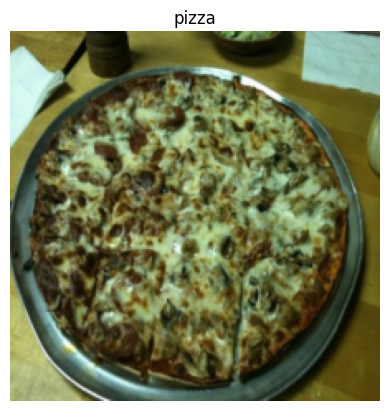

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [32]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

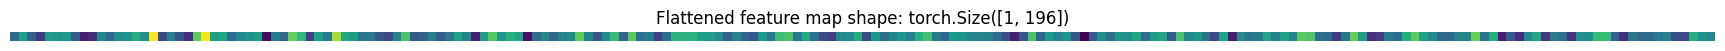

In [35]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [ ]:
from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        patch_size: int = 16,
        embedding_dim: int = 768
    ):
        super().__init__()

        # [batch_size, color_channels, height, width] -> [batch_size, embedding_dim, feature_height, feature_width]
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        # [batch_size, embedding_dim, feature_height, feature_width] -> [batch_size, embedding_dim, feature_height * feature_width]
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
        # [1, 196, 768] -> [1, 197, 768]
        self.class_token = nn.Parameter(
            torch.randn(1, 1, embedding_dim, requires_grad=True)
        )

        # Adds random values to [1, 197, 768]
        self.position_embedding = nn.Parameter(
            torch.randn(1, PATCHES_AMOUNT+1, embedding_dim, requires_grad=True)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % PATCH_SIZE == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {PATCH_SIZE}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        x_permuted = x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]  

        x_with_class_embedding = torch.cat((self.class_token, x_permuted), dim=1)
        x_with_class_and_positional_embedding = x_with_class_embedding + self.position_embedding
        return  x_with_class_and_positional_embedding

In [47]:
random.seed(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 197, 768])


In [48]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attn_dropout: float = 0):
        super().__init__()

        # Create the Norm Layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MSA Layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

In [49]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_embedded_image)
print(f"Input shape of MSA block: {patch_embedded_image.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [50]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072, # From ViT-Base
                 dropout: float = .1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [51]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [52]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = .1,
                 attn_dropout: float = .0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, 
                                                     num_heads=num_heads, 
                                                     attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [53]:
from torchinfo import summary
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [54]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [55]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout,
                                                                            attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        print(self.position_embedding.shape, x.shape)
        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        print(self.position_embedding.shape, x.shape)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [78]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [79]:
torch.manual_seed(42)

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.4581, -1.3238,  0.0607]], grad_fn=<AddmmBackward0>)

In [81]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 197, 768]        152,064              True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 